![alt text](https://www.signavio.com/wp-content/uploads/2013/03/Logo-Universitaet-Osnabrueck-300x99.png)


**PROJECT REPORT**

*Implementing ANNs with Tensorflow  (8.3304)*


**Double DQN (Hasselt et al. 2015)**

Tensorflow Implementation for Solving OpenAI Gym Environments

**Participants**

Saurabh Mishra, Deepak Pathak, Krupal Shah, Christian Johnson

### Imports and Setup

Import git repository into current session using below command to download code and trained model

`!git clone https://github.com/dpkpathak/ANNTFPROJ.git`

In [ ]:
# remove if directory already exists
!rm -rf ANNTFPROJ/
# clone the repository from github
!git clone https://github.com/dpkpathak/ANNTFPROJ.git

# Change current working directory to the git repository.
import os
os.chdir('ANNTFPROJ')

In [1]:
import tensorflow as tf

### Motivation

In this project we aimed to implement the Double Deep Q Network (DDQN) reinforcement learning algorithm proposed by Hasselt et al. in their 2015 paper. The Q-learning algorithm, which updates Q-value estimations for any given state-action pair via the Bellman equation, and its Neural-Network-based equivalent for more complex environments, Deep Q-learning (DQN), were shown by Hasselt and his colleagues to lead to systematic overestimation of Q-values as a result of single-network Q-value estimation from maximum predicted values. In short, because the primary Q-value estimation network chooses a maximum estimation, in especially noisy environments these overestimations can compound and negatively affect training in specific states, leading to, ultimately, suboptimal policies. In this project we aimed understand the motivations for this algorithm and recreate the comparative improvements shown by Hasselt and his colleagues. Thus, our report first explores several previous algorithms motivating the main implementation algorithm.

### Theoretical Background

#### Basics and Q Learning

The DDQN algorithm is motivated by the limitations of several previous algorithms. Thus, we begin with a short overview of these algorithms to motivate our implementation and provide the necessary theoretical background for understanding why the DDQN algorithm is advantageous. 

The original Q Learning algorithm, first sketched by Watkins in his 1989 PhD thesis, is a reinforcement learning algorithm for controlling Markov decision processes via incremental policy adjustment (Watkins, 1989). In its tabular implementation, an agent learns to effectively estimate Q-values for any state-action pair by updating values in a state-action matrix via the Bellman equation, which uses the weighted average of old values plus information from recent episodes. The below procedure summarizes this algorithm and the Bellman equation.

##### Algorithm

- Procedure Q-Learning($\epsilon, \alpha, \gamma$):
    - Initialize $Q(s,a)$ for all $s\in S, a \in A$ arbitrarily except $Q(terminal,\cdot) = 0$
    - $\pi \gets \epsilon$-greedy policy with respect to Q
    - **for** each episode **do**
        - Set $s_1$ as starting state
        - $t \gets 1$
        - **loop** untlil episode terminates
            - Sample action $a_t$ from plolicy $\pi(s_t)$
            - Take action $a_t$ and observe reward $r_t$ and next state $s_{t+1}$
            - $Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha[r_t + \gamma\max\limits_{a'}Q(s_{t+1},a') - Q(s_t, a_t)]$
            - $\pi \gets \epsilon$-greedy policy with respect to Q(policy improvement)
            - $t \gets t+1$
    - return $Q, \pi$

 

The cell below shows the results of a tabular implementation of the Q-Learning algorithm for a simple stochastic environment.


**Environment detail for this example:**

(Adapted from Rubikscode)
<img src="https://i0.wp.com/rubikscode.net/wp-content/uploads/2020/01/Simple-MDP.png?w=1080&ssl=1">

This is one simple environment with 4 states: X, Y, Z and W. X is starting state , while states Z and W are terminal. There are two actions that agent can take in state X – UP and DOWN. Reward fro taking these actions is 0. The interesting part is the set of actions from state Y to W. The reward for this set of actions follows normal distribution with mean -0.5 and standard deviation 1. This means that after a large number of iterations reward will be negative.

This in turn means that our learning agent should never pick the action UP from the state X in the first place, if it wants to minimize the loss, i.e. the goal of the agent would actually be to get reward 0, or the least negative value. This is where Q-Learning has problems. Because we have that specific distribution of reward learning agent can be fooled that it should take action UP in the state X. In a nutshell, max operator updates the Q-Value, which could be positive for this action, learning agent takes this action as valid option. Q-Value is overestimated! 


#test : 1900


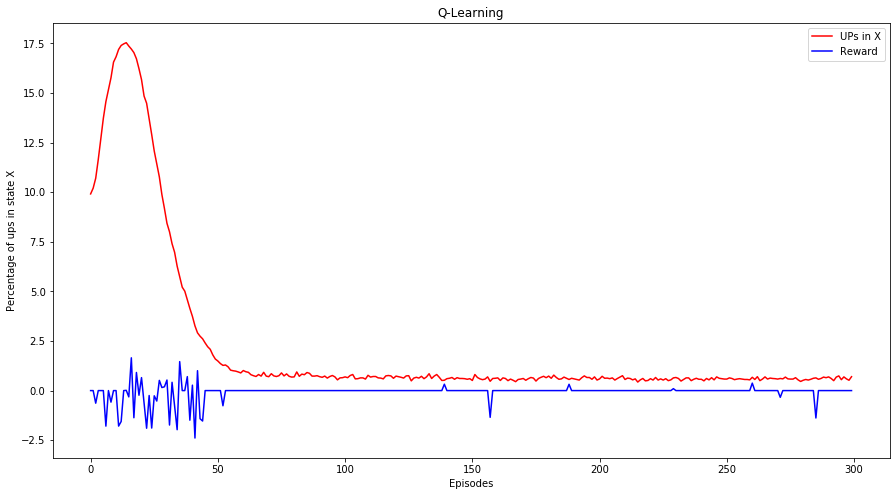

In [2]:
import matplotlib.pyplot as plt
from q_learn.q_learning import MDP, mdp_q_learning
from q_learn.double_q_learning import mdp_double_q_learning

from utility.custom_object import CustomObject

mdp_environment = MDP()
q_learn_obj = CustomObject()
q_learn_obj.q_reward, q_learn_obj.q_table, q_learn_obj.num_of_ups = mdp_q_learning(mdp_environment)

plt.figure(figsize=(15, 8))
plt.plot(q_learn_obj.num_of_ups / 10000 * 100, label='UPs in X', color='red')
plt.plot(q_learn_obj.q_reward, color='blue', label='Reward')
plt.legend()
plt.ylabel('Percentage of ups in state X')
plt.xlabel('Episodes')
plt.title(r'Q-Learning')
plt.show()

#### Double Q Learning

One problem with the Q Learning algorithm is that Q-value estimation and action selection are both performed by the same approximation function, in the above case, the estimations produced by combining the Bellman equation with previous state-action table values. Because the maximum Q-value is used for the update (see above equation), in noisy environments the agent will tend to update the policy based on overestimations which ultimately slow training. 

The solution to this problem, proposed by Hasselt, is to introduce a second approximation function which is randomly updated in deference to the other (Hasselt, 2010). When selecting an action, the approximation function used is separate from that evaluating the action, thus achieving the decoupling required to remove overestimations. The so-called Double Q Learning algorithm is especially effective in noisy environments. The image below summarizes the updated algorithm. Note that either approximation function is updated by random choice and that when updating, the other function is used for value approximation.
##### Algorithm

- Algorithm Double Q-learning
    - Initialize $Q^A, Q^B, s$
    - **repeat**
        - Choose $a$, based on $Q^A(s, \cdot)$, observe $r, s'$
        - Choose (e.g. random) either *UPDATE(A)* or *UPDATE(B)*
        - **if** UPDATE(A) **then**
            - Define $a^* = \arg\max_a Q^A(s',a)$
            - $Q^A(s,a) \gets Q^A + \alpha(s,a)(r + \gamma Q^B(s',a^*) - Q^A(s,a))$
        - **else if** UPDATE(B) **then**
            - Define $b^* = \arg\max_a Q^B(s',a)$
            - $Q^B(s,a) \gets Q^B + \alpha(s,a)(r + \gamma Q^A(s',a^*) - Q^B(s,a))$
        - **end if**
        - $s \gets s'$
    - **until** end


The cell below shows the results of a tabular implementation of this algorithm in the same stochastic environment. Note that training results are improved versus the original Q-Learning algorithm, shown in the number of times the agent selects the unrewarding 'UP' action. This is because the agent is able to avoid the adverse effects of noise-induced overestimation by distributing experiences across the two decoupled approximation functions. In the following graph you can see the two algorithms compared.

#test : 1900


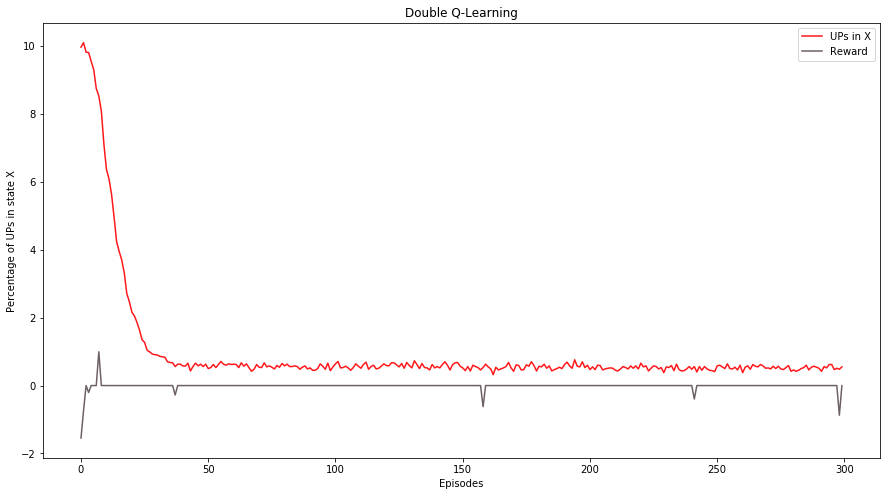

In [3]:
mdp_environment = MDP()
dq_learn_object = CustomObject()
dq_learn_object.reward, _, _, dq_learn_object.num_of_ups = mdp_double_q_learning(mdp_environment)
plt.figure(figsize=(15, 8))
plt.plot(dq_learn_object.num_of_ups / 10000 * 100, label='UPs in X', color='#FF171A')
plt.plot(dq_learn_object.reward, color='#6C5F66', label='Reward')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Double Q-Learning')
plt.show()

The cell below shows the results side-by-side. The Q-learning agent explores the unrewarding UP action much more than the Double Q-learning agent during initial stages episodes, due to the overestimation of the stochastic rewards for this action which are neatly avoided by the Double Q-learning agent. Thus, although both agents can ultimately reach an optimal policy, the Double Q-learning agent is more efficient.

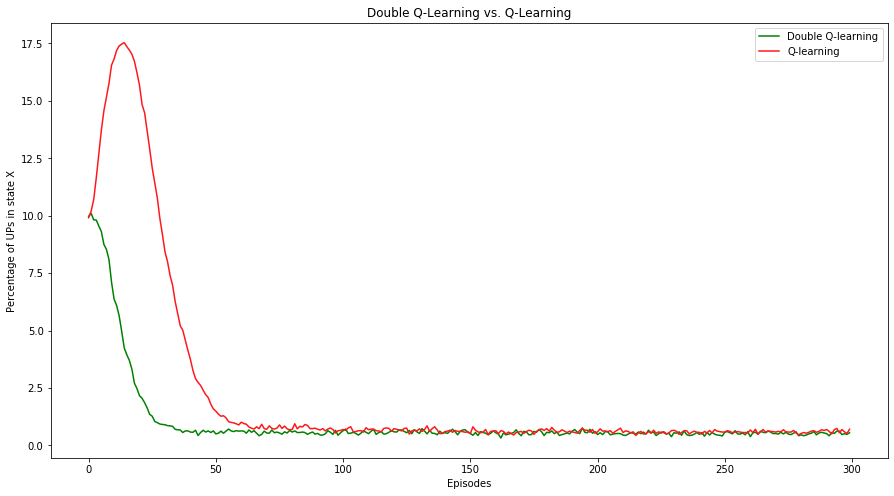

In [4]:
plt.figure(figsize=(15,8))
plt.plot(dq_learn_object.num_of_ups/10000*100, label='Double Q-learning', color='g')
plt.plot(q_learn_obj.num_of_ups/10000*100, label='Q-learning', color='#FF171A')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Double Q-Learning vs. Q-Learning')
plt.show()

### Deep Q Learning

In more complex environments, such as OpenAI gym environments, a tabular representation is infeasible because of the sheer amount of state-action pairs. Thus, a more efficient means of updating and representing the agent policy is by introducing a neural network to replace the tabular approximation function. By iteratively training a network on batches of experiences, Mnih et al showed that neural reinforcement learning is an effective update to the original Q-Learning algorithm (Mnih et al, 2015).

In the following cells we will walk through and explain the relevant sections of the DQN implementation, which will be relevant for the DDQN implementation as well.

For the implementation of the DQN and Double DQN algorithms, we have kept the hyper parameters identical for as done in Hasselt et al. 2015, but instead of using the Atari game environment, we are using Classic control environments from OpenAI Gym  because of computational resource limitations.

We have used the following hyperparameters:<br>

`max_epsilon=1` (maximum probability to select random action from action space used in greedy learning policy)<br>
`min_epsilon = 0.01` (minimum probability to select random action from action space used in greedy learning policy)<br>
`lambda_ = 0.0005` (rate of decay of probability of selecting random action while training agent for greedy policy)<br>
`gamma = 0.95` (discount factor for future rewards)<br>
`batch_size = 32` (training batch size)<br>
`tau=0.08` (factor of weights to transfer in double dqn )<br>
`max_experiences=400000` (Upper limit of number of experience(queue) for experience replay)<br>
`min_experiences = 96`(Lower limit of number of experience(queue) for experience replay)<br>
`hidden_units =[30,30]` (Number of neurons in hidden layers.)<br>
`lr =0.001` (Learning rate for optimizer ) <br>
`num_episodes = 300` (Number of Episode for training)<br>

The complete implementation of these two algorithm resides in `./dqn_and_ddqn/agent.py` file. We will explain main components on the algorithm and its implementation here. In this section we will cover Deep Q-learning only.

`Qnetwork` class is the base network which will be used in both DQN and DDQN. The constructor of the class takes following parameters: `num_states`: number of parameters to encode a state in the environment, `hidden unit`: takes list of intergers which represent number of neuron in each layer, `num_actions`: number of possible action in the environment.

`num_states` works as input shape for the network, as we pass state of the environment to get q-values for all possible action. Similarly, `num_actions` decides number of output node in the network.

In [5]:
## Q network 
# Base network for DQN and DDQN

class Qnetwork(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(Qnetwork, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for units in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                units, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()))
        self.output_layer = tf.keras.layers.Dense(num_actions)

    @tf.function
    def call(self, inputs):
        x = self.input_layer(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

In below cell we present DQN Agent, which we will use for training the DQN algorithm.

`DQNAgent` class:

The DQNAgent has two important functions:

The `get action()` method will select the next action the agent should take, given the current state of the environment. In this function we implement the so-called 'epsilon greedy policy', which allows the agent to explore the environment during early episodes, and, as the epsilon value decays, encourage the agent to exploit the environment based on  previous training. To implement this policy there is a random switch which enforces either the explore or exploit strategy based on the decaying epsilon value. We update the epsilon value during the main training loop. 

The `train()` method receives a batch of tuple containg current state, action, reward, and next state, to perform a gradient step following below equation to calculate target value. In later cells we will explain the algorithm in greater detail:

$$Y^{DQN}_t \equiv R_{t+1} + \gamma\max_aQ(S_{t+1}, a, \theta)$$

where $\theta$ is network parameter.



<blockquote>
    
```python
class DQNAgent:
    def __init__(self,train_net,gamma,batch_size,num_actions,num_states):
        self.train_net = train_net
        self.gamma = gamma
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam()
        self.mse = tf.keras.losses.MeanSquaredError()
        self.num_actions = num_actions
        self.num_states = num_states


    def get_action(self,state,eps):
        if random.random() < eps:
            return random.randint(0, self.num_actions - 1)
        else:
            return np.argmax(self.train_net(state.reshape(1, -1)))

    def train(self,exp_buffer):
    
        if len(exp_buffer.experiences) < exp_buffer.min_experiences:
            return 0

        ids = np.random.randint(low=0, high=len(exp_buffer.experiences), size=self.batch_size)
        states = np.asarray([exp_buffer.experiences[id_][0] for id_ in ids])
        actions = np.asarray([exp_buffer.experiences[id_][1] for id_ in ids])
        rewards = np.asarray([exp_buffer.experiences[id_][2] for id_ in ids])
        next_states = np.asarray([(np.zeros(self.num_states)if exp_buffer.experiences[id_][3] is None else 
                                   exp_buffer.experiences[id_][3]) for id_ in ids])

        # Obtaining Q from states
        Q = self.train_net(states)
        #print(states.shape)
        # Obtaining Q prime from next states
        
        Q_prime = self.train_net(next_states)

        # computation of target q 
        Q_t = Q.numpy()
        updates = rewards

        #valid ids those which doesn't have next states 0
        valid_idxs = np.array(next_states).sum(axis=1) != 0
        batch_idxs = np.arange(self.batch_size)

        updates[valid_idxs] += self.gamma * np.amax(Q_prime.numpy()[valid_idxs, :], axis=1)

        Q_t[batch_idxs, actions] = updates

        with tf.GradientTape() as tape:
            output = self.train_net(states)
            loss = self.mse(Q_t, output)
            gradients = tape.gradient(loss, self.train_net.trainable_variables)
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.train_net.trainable_variables))
        return loss

```

</blockquote>



The `train_dqn()` method in class Gameagent(shown later) houses the main training loop for the agent. Here we do not 
implement algorithm specifics, but iterate through the episodes and update the 
epsilon value and relevant experiment variables such as training loss. The 
relevant section here is the experience update. Found in the while loop of the 
current episode:

<blockquote>
    
```python
while True:
  # First, the agent selects an action using the 'get action' function.
  action = self.get_action(state, eps)

  # This action influences the rewards and next state of the environment.
  next_state, reward, done, info = env.step(action)
  reward = np.random.normal(1, 1)
  if done:
    next_state = None

  # This result is stored as an agent experience. The
  # experiences are stored in a memory object attached to the agent. This
  # object handles storage and access of batches of previous experiences
  # for training the networks which replace the tabular approximation
  # function from the Q-learning algorithm. 
  self.experience_buffer.add_experiences((state, action, reward, next_state))

  # We compute the loss and update the approximation function. Complete
  # details of this function will be explained later.
  loss = self.train(self.experience_buffer)
  avg_loss += loss
  state = next_state
  steps += 1

  # We also update the epsilon value, decaying it according to the 'lambda'
  # hyperparameter.
  eps = min_epsilon + (max_epsilon - min_epsilon) * math.exp(-lambda_ * steps)
  
  # break the loop if episode terminates
  if done:
      # update loss and reward variables and break from while loop
      break

```

</blockquote>



You can see how the implementation of the DQN algorithm begins to 
differ from that of the tabular Q-learning algorithm by the introduction of the experience object which replaces the original table for storing state-action reward pairs. Because there are too many state-action pairs, rather than storing rewards in specific cells of a table, we store all collected memories and then batch these to iteratively train the network to approximate the expected reward and Q value based on this training data. Within the main approximation function update loop of the agent, we will access these memories to train the functions and ultimately the agent.

The 'train' function implements the main update steps from the DQN algorithm, 
which will ultimately differ slightly from the DDQN algorithm by the number
of integrated networks. During each step of the main training loop, after 
selecting an action we update the network by training it on a batch of 
experiences from the experience object. First we gather an appropriate batch, and
then use the network to compute the values necessary for the Q-learning algorithm.

<blockquote>
    
```python

# First, we estimate the Q value for the current state.
Q_train = self.train_net(states)

# Then the Q value for the next state.
Q_train_prime = self.train_net(next_states)
```

</blockquote>

According to the Q-learning algorithm, the value for the current state added 
to the prediction for next states will be used to update this state action pair.
As we are doing this with a network, it is a bit more complicated than just 
looking up the appropriate values in a table and computing the new Q value. We must
ultimately create a target value based on the batch of experiences which we will 
use to train the network to better approximate the value. 

With reference to the Q learning algorithm from before, we see that we have already implemented the first bullet points of the main training loop. The reward value is collected from the random sample of experiences:


- **loop** untlil episode terminates
    - Sample action $a_t$ from plolicy $\pi(s_t)$
    - Take action $a_t$ and observe reward $r_t$ and next state $s_{t+1}$
    - $Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha[r_t + \gamma\max\limits_{a'}Q(s_{t+1},a') - Q(s_t, a_t)]$
    
    
From the third bullet point, we want to update the Q-value based on 
a combination of the current and maximized next state values. In terms of the 
neural network, this means that instead of performing the equation above
verbatim, we must first compute the maximized Q-value (the part inside of the brackets)
to determine the expected reward of the current action and the following states.
These will ultimately be used to compute the loss in order to train the network.

<blockquote>
    
```python
# We begin with the training Q value from the equation below. This is the first
# Q value after the arrow. We need to compute the rest to combine with this 
# value in order to determine the full network target value needed for the update.
Q_train_target = Q_train.numpy()

# First we set the rewards as the update we will ultimately feed to the network.
updates = rewards

# For training we want to use only 'valid' ids from the batch of experiences, 
# ie those without next state == 0.
valid_idxs = np.array(next_states).sum(axis=1) != 0
batch_idxs = np.arange(self.batch_size)

```

</blockquote>

Next, we add to those rewards (the 'updates' variable), the rest of the info
from inside the brackets: the maximized estimation of the next state Q value,
tempered by the next-state discount factor. Note that we do not
compute the difference between the next and current state, as this is undertaken
during the backpropogation step of the network training. We also do not need
to explicitly code the learning rate, alpha, because this is integrated into the 
optimizer functions from Keras. Here we use the default value from the Adam 
optimizer.

<blockquote>
    
```python
if self.algorithm == 'dqn':    
  updates[valid_idxs] += self.gamma * np.amax(Q_train_prime.numpy()[valid_idxs, :], axis=1)

# We then 'perform' the update by combining the original predicted value with the 
# weighted Q value for next states. Remember, we still do not have the difference
# between the previous and next state values, so we will need to compute the loss
# before we can update the network.
Q_train_target[batch_idxs, actions] = updates

# We compute the loss by having the network predict on the current state
# and then observing the difference between the prediction and the update we 
# previously computed. This implements the final section of the bracketed equation.
with tf.GradientTape() as tape:
  output = self.train_net(states)
  loss = self.mse(Q_train_target, output)
  gradients = tape.gradient(loss, self.train_net.trainable_variables)

# Now, the entire right portion of the equation is computed and we can update the
# network based on the gradients.
self.optimizer.apply_gradients(zip(gradients, self.train_net.trainable_variables))

```

</blockquote>

We perform this update at every stage of the episode while loop, per the 
Q-learning algorithm. As the network accumulates experiences, given that it 
will train on a maximization of the Q values, the agent will gradually
optimize to choose actions which result in the highest Q-values.

Later we will show the results of our experiments and compare DQN and DDQN performance on several environments.

### Deep Reinforcement Learning with Double Deep Q Learning


The DDQN algorithm is the Double Q-learning version of the DQN algorithm. In their 2015 paper, Hasselt et al. investigated the performance of the aforementioned DQN algorithm and showed that it also produces systematic non-uniform overestimations which lead to suboptimal agent policies. Since the introduction of the Q-learning algorithm in 1989, it was known that this algorithm sometimes led to suboptimal policies and overestimated values, but the exact causes or solutions for these inadequacies were unknown (Watkins, 1989). As early as 1993, it was hypothesized that inflexible function approximations and noise led to such overestimations, and in their paper, Hasselt et al experimentally demonstrate the truth of these hypotheses in relation to the network update procedures of the DQN algorithm (Thrun & Schwartz, 1993).

Because the DQN algorithm ultimately trains only one Q-value approximation network, the algorithm reproduces same unnecessary conjunction of action selection and evaluation from Q learning, which, if decoupled, could lead to a uniform estimation distribution which would mitigate the effects of overestimation. Effectively, if all Q-values are equally overestimated i.e. in a normal distribution, then overestimation becomes a non-issue for the training protocol, and this uniformity can be achieved by the introduction of an additional Q-value into the original Q/DQN-learning algorithm. In the DDQN algorithm, estimation uniformity is achieved by requisitioning the target network's parameters and, rather than simply copying them from the online network, using them in conjunction with the online network to randomly update either one of two sets of parameters, θ or θ', representing the parameters of the online or target network, respectively. As Hasselt et al state, "... two value functions are learned by assigning experience randomly to update one of the two value functions, such that there are two sets of weights ..." (Hasselt et al., 2015).

It is worth noting that Hasselt's proposal for implementing the DDQN algorithm still involves only two networks rather than four, which could be implied given that the DQN algorithm involves two networks and implements only a single Q-value. In Hasselt's estimation, leveraging the DQN target network for representing the second Q-value function is "the minimal possible change to DQN towards Double Q-Learning. The goal is to get most of the benefit of Double Q-Learning, while keeping the rest of the DQN algorithm intact for a fair comparison" (Hasselt et al, 2015, p4). Thus, in our implementation we stick with the two network structure suggested by Hasselt et al, conceding that other interpretations of the DDQN algorithm are possible.

By randomly selecting updates for the Q and Q' approximation functions, the Double Q-learning algorithm is able to remove the non-uniform estimation biases seen in the single-Q-value learning algorithms. Hasselt et al demonstrate these results in the following graph, which shows that when estimating Q values with a single approximation function, as the number of actions increases, the estimations (red) systematically increase. However, when an additional approximation function (blue) is introduced, there appears no overestimation bias as a function of increasing number of actions, suggesting that the suboptimal policy training is mitigated by the additional value. In our project we intended to replicate these results by implementing the Double Deep Q learning algorithm, which uses two neural networks for approximating the separate Q-values.


![alt text](http://drive.google.com/uc?export=view&id=1SNdOFx9PpIeRewXuWarM6CqiQXbkRcXj)

In our implementation, the DDQN agent uses the same 'Agent' class as for the DQN
agent, but with a few minor tweaks. As mentioned, because we are using two 
approximation functions, we must pass two networks to the agent, a training 
and a target network which will be used to separate action selection and 
evaluation and will ultimately be combined in the equation used to update
the network.

<blockquote>
    
```python

class DDQNAgent:
    def __init__(self,train_net,target_net,gamma,batch_size,num_actions,num_states,tau):
        self.train_net = train_net
        self.target_net = target_net
        self.gamma = gamma
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam()
        self.mse = tf.keras.losses.MeanSquaredError()
        self.num_actions = num_actions
        self.num_states = num_states
        self.tau = tau
        


    def get_action(self,state,eps):
        if random.random() < eps:
            return random.randint(0, self.num_actions - 1)
        else:
            return np.argmax(self.train_net(state.reshape(1, -1)))

    def train(self,exp_buffer):
    
        #Storing some amount of experiences before training
        if len(exp_buffer.experiences) < exp_buffer.min_experiences:
            return 0

        # random selection of ids from the experience replay buffer
        ids = np.random.randint(low=0, high=len(exp_buffer.experiences), size=self.batch_size)
        states = np.array([exp_buffer.experiences[id_][0] for id_ in ids])
        actions = np.array([exp_buffer.experiences[id_][1] for id_ in ids])
        rewards = np.array([exp_buffer.experiences[id_][2] for id_ in ids])
        next_states = np.array([(np.zeros(self.num_states)if exp_buffer.experiences[id_][3] is None else 
                                 exp_buffer.experiences[id_][3]) for id_ in ids])

        #break

        # Obtaining Q values for current state
        Q_train= self.train_net(states)

        # Obtaining Q values for next state
        Q_train_prime = self.train_net(next_states)

        # target q , will be update later
        Q_train_t = Q_train.numpy()

        updates = rewards

        #ids those next states are non zero, those ids are only valid one
        valid_idxs = np.array(next_states).sum(axis=1) != 0
        batch_idxs = np.arange(self.batch_size)

        # Q value Update equation

        A_prime = np.argmax(Q_train_prime.numpy(), axis=1)
        Q_target = self.target_net(next_states)
        updates[valid_idxs] += self.gamma * Q_target.numpy()[batch_idxs[valid_idxs], A_prime[valid_idxs]]
        Q_train_t[batch_idxs, actions] = updates

        with tf.GradientTape() as tape:
            output = self.train_net(states)
            loss = self.mse(Q_train_t, output)
            gradients = tape.gradient(loss, self.train_net.trainable_variables)
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.train_net.trainable_variables))

        #copying train network into target network partially 
        for t, e in zip(self.target_net.trainable_variables, self.train_net.trainable_variables):
            t.assign(t * (1 - self.tau) + e * self.tau)

        return loss
```

</blockquote>

Below, you will see the crucial differences in the training loop which distinguish the DDQN from the DQN algorithm:

<blockquote>
    
```python
# Using the target network, we must compute the next state using this network, thereby
# achieving the separation between selection and evaluation proposed by Hasselt. 
elif self.algorithm == 'ddqn':
  A_prime = np.argmax(Q_train_prime.numpy(), axis=1)
  Q_target = self.target_net(next_states)
  # The update equation then, looks very similar to that from DQN, with the key
  # difference that not the target Q values are integrated as the next state
  # evaluation used for the update. 
  updates[valid_idxs] += self.gamma * Q_target.numpy()[batch_idxs[valid_idxs], A_prime[valid_idxs]]

# We then use the target network to update the training network. Here we make a 
# 'soft' copy of the network according to the parameter tau. At every iteration
# of the update algorithm, we adjust the training network according to the target.
if self.algorithm == 'ddqn':
  for t, e in zip(self.target_net.trainable_variables, self.train_net.trainable_variables):
    t.assign(t * (1 - tau) + e * tau)

```

</blockquote>


##### Gameagent Imlementation:

We will explain only important part of the this `class` relevant for training and visualization:

`__init__()`: contructor will create an agent, which receives environment object, and other hyper parameter for network and training. The agent can be used for either DQN and DDQN based on the chosen training option.

`train_ddqn()`: this method follow double dqn method to train the netowrk using `DDQNAgent` class.
`train_dqn()`: this method follow dqn method to train the netowrk using `DQNAgent` class.

`visualise()`: this method is used to visualize the losses and rewards observed while training.

To present result in this notebook, we have trainined the model separately and saved trained network and training metrics using `save_weights()` and `save_training_variable()` methods respectively, and we load in the model and training metics using `load_weights()` and `load_training_variable()` methods.

Other methods are used for visualization of environment in form of video after training the model.

In [6]:
class Gameagent:
    def __init__(self,environment,max_epsilon=1,min_epsilon = 0.01,lambda_ = 0.0005,
    gamma = 0.95, batch_size = 32, tau=0.08, max_experiences=400000,
    min_experiences = 96,hidden_units =[30,30], lr =0.001,num_episodes = 300):
        #Define global varaiables
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.lambda_ = lambda_
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

        self.hidden_units = hidden_units
        self.lr = lr
        self.env = environment
        self.env_name = self.env.unwrapped.spec.id
        
        
        self.num_actions = self.env.action_space.n

        self.num_states = len(self.env.observation_space.sample())


        self.num_episodes = num_episodes

        self.total_rewards = np.empty( self.num_episodes)
        self.total_loss = np.empty( self.num_episodes)
        
        #Experience buffer object
        self.exp_buffer = ExperienceBuffer(self.max_experiences, self.min_experiences)
        
        ## DQN object
        self.dqn = Qnetwork(self.num_states,  self.hidden_units,  self.num_actions)
        self.agent = DQNAgent( self.dqn, self.gamma, self.batch_size,  self.num_actions,self.num_states)
        
        ## Double DQN objects
        self.train_net = Qnetwork(self.num_states, self.hidden_units, self.num_actions)
        self.target_net = Qnetwork(self.num_states, self.hidden_units, self.num_actions)
        self.DDQagent = DDQNAgent(self.train_net,self.target_net,self.gamma,self.batch_size,self.num_actions,self.num_states,self.tau)
        
    ## Game play function
    # Function to show the game play 

    def show_video(self):
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
        else: 
            print("Could not find video")


    def wrap_env(self):
        self.env = Monitor(self.env, './video', force=True)
        return self.env

    ## Making video of testing phase of the environment

    def make_video(self,agent):
        self.env = self.wrap_env()
        rewards = 0
        steps = 0
        done = False
        state = self.env.reset()
        while not done:
            self.env.render()
            action = agent.get_action(state,0)
            state, reward, done, info= self.env.step(action)
            steps += 1
            rewards += reward
        print("Testing steps: {} rewards {}: ".format(steps, rewards))
    
    def visualise(self,train_steps,train_losses,train_rewards):
        fig = plt.figure(figsize=(16,5))
        loss_ax = fig.add_subplot(1,2,1)
        plt.plot(train_steps,train_losses)
        loss_ax.title.set_text('Loss plot')

        loss_ax.set_xlabel('Episodes')
        loss_ax.set_ylabel('Loss')

        rewards_ax = fig.add_subplot(1,2,2)
        plt.plot(train_steps,train_rewards)

        rewards_ax.title.set_text('Reward plot')

        rewards_ax.set_xlabel('Episode')
        rewards_ax.set_ylabel('Rewards')
        # plt.show()
        fig.suptitle(f'Visualization for {self.agent_name} agent in {self.env_name} environment:', fontsize=16)
        return fig

    def test(self,agent_name):
        if(agent_name == 'dqn'):
            self.make_video(self.agent)
        else:
            self.make_video(self.DDQagent)
        self.show_video()
        
    ## training loop for DQN

    def train_dqn(self):
        eps = self.max_epsilon
        train_steps = []
        train_losses = []
        train_rewards = []
        render = False
        steps = 0
        for i in range( self.num_episodes):
            clear_output(wait=True)
            rewards = 0
            state = self.env.reset()
            iteration = 0
            avg_loss = 0
            while True:
                action = self.agent.get_action(state,eps)
                next_state, reward, done, info = self.env.step(action)
                if done:
                    next_state = None
                # Experience Buffer replay
                self.exp_buffer.add_experiences((state, action, reward, next_state))

                loss = self.agent.train(self.exp_buffer)
                avg_loss += loss

                state = next_state

                # exponentially decay the eps value
                steps += 1
                eps = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-self.lambda_ * steps)

                if done:
                    avg_loss /= iteration
                    rewards = iteration
                    break
                iteration += 1
            train_steps.append(i)
            train_rewards.append(rewards)
            train_losses.append(float(avg_loss))
            print(f"Episode: {i}, Episode Reward: {rewards}, Episode Loss: {avg_loss: .3f}, Epsilon: {eps}")
        return train_steps,train_losses,train_rewards

    ## training loop for DDQN   
    def train_ddqn(self):
        eps = self.max_epsilon
        train_steps = []
        train_losses = []
        train_rewards = []
        render = False
        steps = 0
        for i in range( self.num_episodes):
            clear_output(wait=True)
            rewards = 0
            state = self.env.reset()
            iteration = 0
            avg_loss = 0
            while True:
                action = self.DDQagent.get_action(state,eps)
                next_state, reward, done, info = self.env.step(action)
                if done:
                    next_state = None
                # Experience Buffer replay
                self.exp_buffer.add_experiences((state, action, reward, next_state))

                loss = self.DDQagent.train(self.exp_buffer)
                avg_loss += loss

                state = next_state

                # exponentially decay the eps value
                steps += 1
                eps = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-self.lambda_ * steps)

                if done:
                    avg_loss /= iteration
                    rewards = iteration
                    break
                iteration += 1
            train_steps.append(i)
            train_rewards.append(rewards)
            train_losses.append(float(avg_loss))
            print(f"Episode: {i}, Episode Reward: {rewards}, Episode Loss: {avg_loss: .3f}, Epsilon: {eps}")
        return train_steps,train_losses,train_rewards
    
    ## saving training variables
    
    def save_training_variable(self,agent_name,train_steps,train_rewards,train_losses):
        path = "./assets/"+self.env_name+"/"+agent_name+"/training_variables/"
        try:
            os.makedirs(path)
        except OSError:
            print ("%s Directory already created" % path)
        else:
            print ("Successfully created the directory %s" % path)
        np.save(path+"train_steps",np.array(train_steps))
        np.save(path+"train_rewards",np.array(train_rewards))
        np.save(path+"train_losses",np.array(train_losses))
        
    ## loading training variables
    
    def load_training_variable(self,agent_name):

        self.agent_name = agent_name
        
        train_steps = np.load("./assets/"+self.env_name+"/"+agent_name+"/training_variables/train_steps.npy")
        train_rewards = np.load("./assets/"+self.env_name+"/"+agent_name+"/training_variables/train_rewards.npy")
        train_losses = np.load("./assets/"+self.env_name+"/"+agent_name+"/training_variables/train_losses.npy")
        
        return train_steps,train_rewards,train_losses
    
    ## save weights
        
    def save_weights(self,agent_name):
        path = "./assets/"+self.env_name+"/"+agent_name+"/weights/"
        try:
            os.makedirs(path)
        except OSError:
            print ("%s Directory already created" % path)
        else:
            print ("Successfully created the directory %s" % path)
       
        if(agent_name == 'dqn'):
            self.dqn.save_weights(path+self.env_name+"_"+agent_name+".h5")
        else:
            self.train_net.save_weights(path+self.env_name+"_"+agent_name+".h5")
    
    ## load weights
    # Subclass implementation cannot be load until it called on some data atleast once. 
    # in order to load the weights, have to run model once.
    ## https://www.tensorflow.org/guide/keras/save_and_serialize
    
    def load_weights(self,agent_name):
        if(agent_name == 'dqn'):
            self.num_episodes = 1
            self.exp_buffer = ExperienceBuffer(1, 0)
            t, l, r, = self.train_dqn()
            clear_output(wait=True)
            self.dqn.load_weights("./assets/"+self.env_name+"/"+agent_name+"/weights/"+self.env_name+"_"+agent_name+".h5")
        else:
            self.num_episodes = 1
            self.exp_buffer = ExperienceBuffer(1, 0)
            t, l, r, = self.train_ddqn()
            clear_output(wait=True)
            self.train_net.load_weights("./assets/"+self.env_name+"/"+agent_name+"/weights/"+self.env_name+"_"+agent_name+".h5")
        

### Results

#### Results for DQN Algorithm:
##### Traing results:

C:\Users\deepa\.conda\envs\rl\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


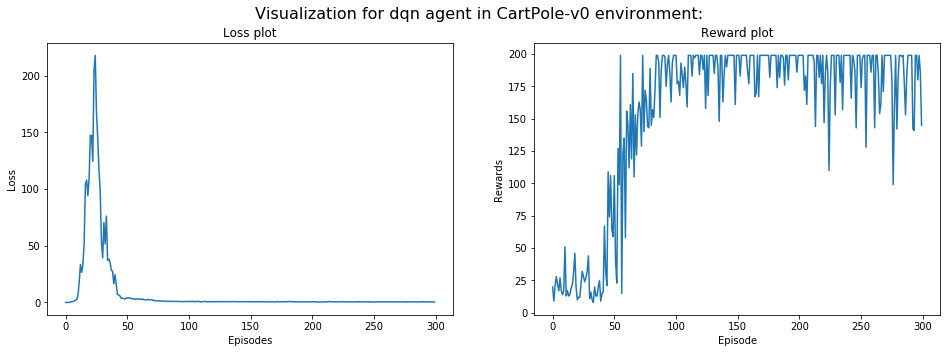

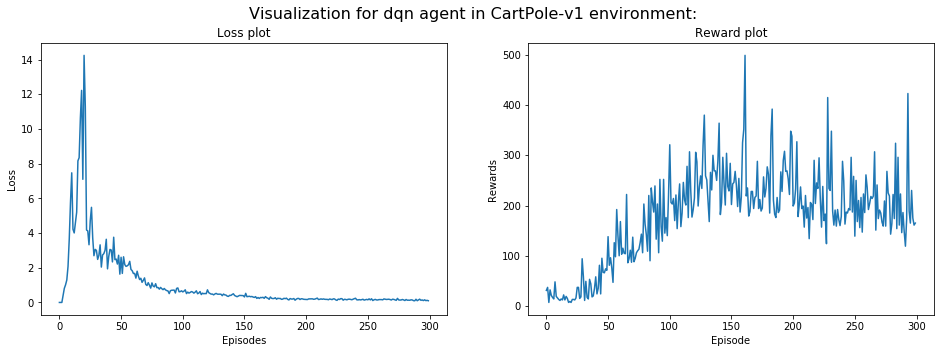

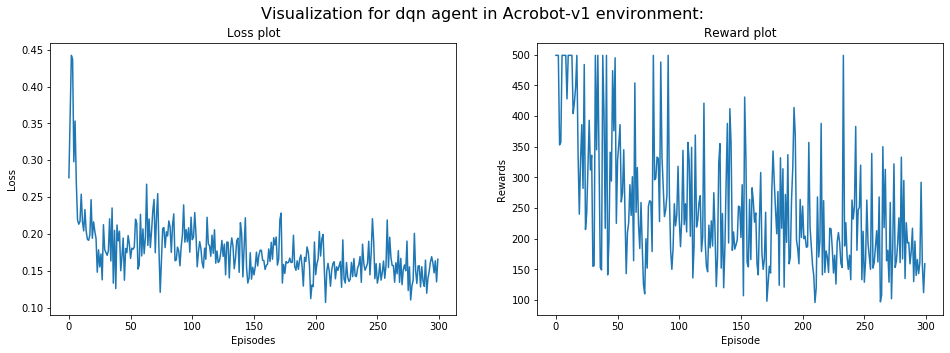

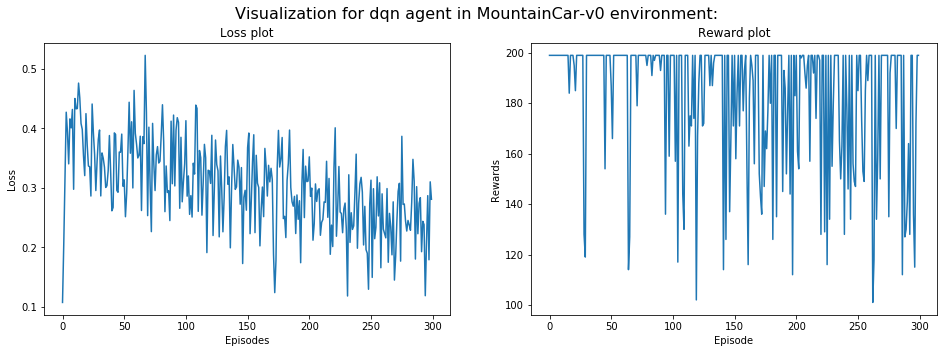

In [7]:
# load and visualize the result for all env
import gym
from statistics import mean
import pandas as pd

from dqn_and_ddqn import agent

num_episodes = 5
environment_list = ["CartPole-v0","CartPole-v1","Acrobot-v1","MountainCar-v0"]
agent_name = "dqn"
figs = []
minimum_reward =[]
maximum_reward =[]
average_reward =[]
results = []
for env_name in environment_list:
    environment = gym.make(env_name)

    player = agent.Gameagent(environment=environment)
    
    # Loading weight must run once the model as suggested here
    # https://www.tensorflow.org/guide/keras/save_and_serialize
    with tf.device('/device:CPU:0'):
        player.load_weights(agent_name)
        figs.append(player.visualise(*player.load_training_variable(agent_name)))
        test_rewards=[]
        for episode in range(num_episodes):
            reward = player.test(agent_name)
            test_rewards.append(reward)
    minimum_reward.append(min(test_rewards))
    maximum_reward.append(max(test_rewards))
    average_reward.append(mean(test_rewards))
minimum_reward.reverse()
average_reward.reverse()
maximum_reward.reverse()
figs.reverse()
for env_name in environment_list:
    figs.pop().show()
    results.append([env_name, minimum_reward.pop(), maximum_reward.pop(), average_reward.pop()])

##### Test results:

In [8]:
results = pd.DataFrame(results, columns=["Environment", "Max. reward", "Min. reward", "Avg. reward"]).set_index("Environment")
results

,Max. reward,Min. reward,Avg. reward
Environment,,,
CartPole-v0,200.0,200.0,200.0
CartPole-v1,142.0,319.0,198.6
Acrobot-v1,-84.0,-71.0,-78.4
MountainCar-v0,-200.0,-200.0,-200.0


#### Results for DDQN Algorithm:
#### Training results:

C:\Users\deepa\.conda\envs\rl\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


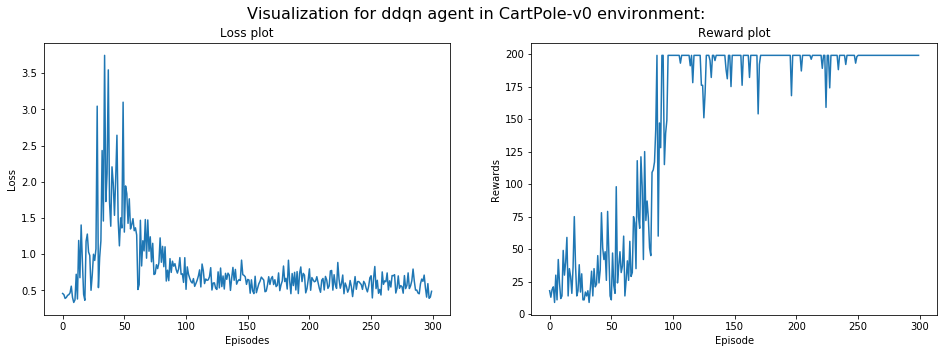

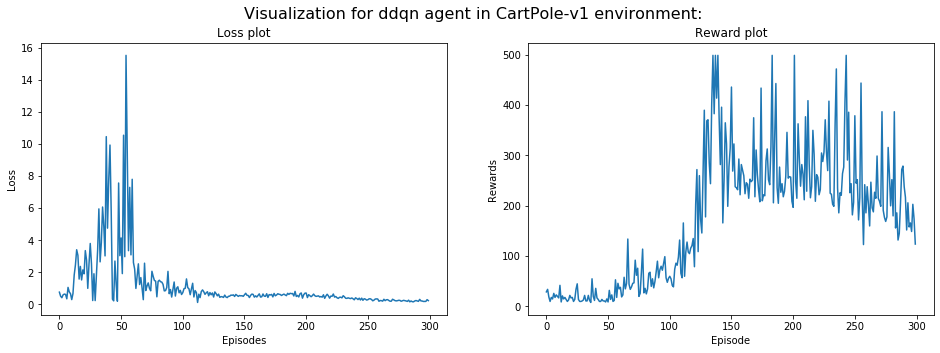

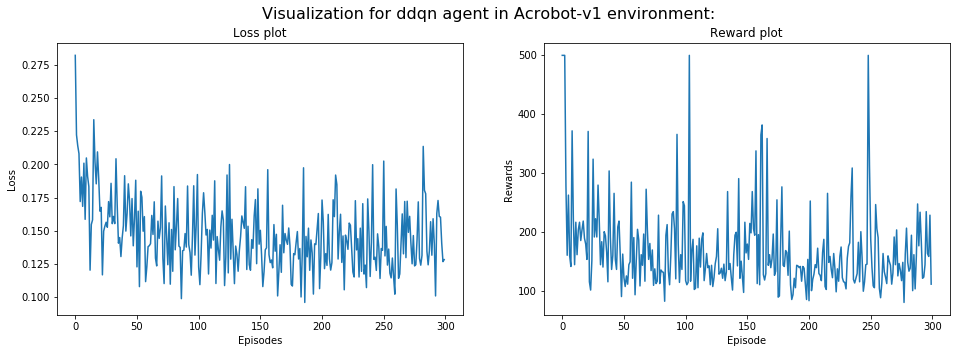

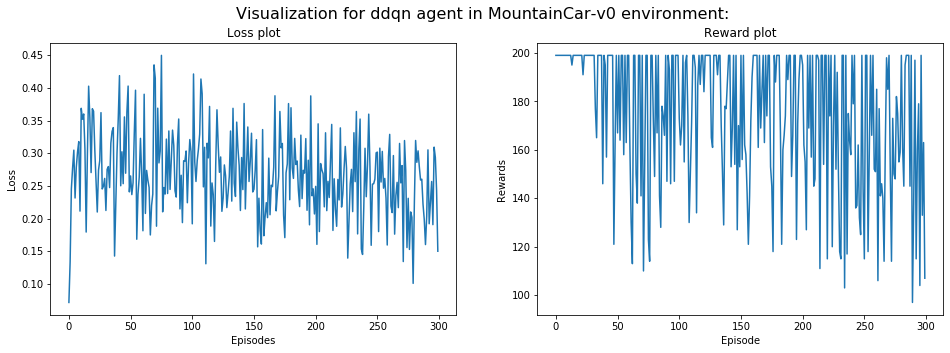

In [9]:
# load and visualize the result for all env
import gym
from statistics import mean
import pandas as pd

from dqn_and_ddqn import agent

num_episodes = 5
environment_list = ["CartPole-v0","CartPole-v1","Acrobot-v1","MountainCar-v0"]
agent_name = "ddqn"
figs = []
minimum_reward =[]
maximum_reward =[]
average_reward =[]
results = []
for env_name in environment_list:
    environment = gym.make(env_name)

    player = agent.Gameagent(environment=environment)
    
    # Loading weight must run once the model as suggested here
    # https://www.tensorflow.org/guide/keras/save_and_serialize
    with tf.device('/device:CPU:0'):
        player.load_weights(agent_name)
        figs.append(player.visualise(*player.load_training_variable(agent_name)))
        test_rewards=[]
        for episode in range(num_episodes):
            reward = player.test(agent_name)
            test_rewards.append(reward)
    minimum_reward.append(min(test_rewards))
    maximum_reward.append(max(test_rewards))
    average_reward.append(mean(test_rewards))
minimum_reward.reverse()
average_reward.reverse()
maximum_reward.reverse()
figs.reverse()
for env_name in environment_list:
    figs.pop().show()
    results.append([env_name, minimum_reward.pop(), maximum_reward.pop(), average_reward.pop()])

##### Test result:

In [10]:
results = pd.DataFrame(results, columns=["Environment", "Max. reward", "Min. reward", "Avg. reward"]).set_index("Environment")
results

,Max. reward,Min. reward,Avg. reward
Environment,,,
CartPole-v0,200.0,200.0,200.0
CartPole-v1,126.0,144.0,132.6
Acrobot-v1,-500.0,-500.0,-500.0
MountainCar-v0,-200.0,-95.0,-172.4


### Discussion

The results suggest the predicted improvements of the DDQN algorithm while also revealing potential areas of weakness and flaws in the implementation. Notably, the DDQN algorithm performs better during training in the Cartpole v0 environment, more efficiently reaching the optimal policy. Interestingly, in the Cartpole v1 continuous environment, the DQN seems to reach a more stable policy, as indicated by the rewards during training. This result is somewhat corroborated by the findings of Hasselt et al, as it was found that for some Atari games, the DQN algorithm performs better. Finally, we see that the training results of the MountainCar and Acrobot environments are largely unsuccessful, likely because of insufficient training time or inadequately tuned networks, given that our class and training loop structure train all agents on the same configuration of networks and episodes.

### References

* Hasselt, Hado. (2010). Double Q-learning.. 2613-2621. 

* Hasselt, Hado & Guez, Arthur & Silver, David. (2015). Deep Reinforcement Learning with Double Q-learning. 

* Mnih, Volodymyr & Kavukcuoglu, Koray & Silver, David & Rusu, Andrei & Veness, Joel & Bellemare, Marc & Graves, Alex & Riedmiller, Martin & Fidjeland, Andreas & Ostrovski, Georg & Petersen, Stig & Beattie, Charles & Sadik, Amir & Antonoglou, Ioannis & King, Helen & Kumaran, Dharshan & Wierstra, Daan & Legg, Shane & Hassabis, Demis. (2015). Human-level control through deep reinforcement learning. Nature. 518. 529-33. 10.1038/nature14236. 

* Watkins, Christopher. (1989). Learning From Delayed Rewards. PhD Thesis. University of Cambridge.

* Thrun, Sebastian & Schwartz, Anton. (1993). Issues in Using Function Approximation for Reinforcement Learning. In Proceedings of the Fourth Connectionist Models Summer School. Erlbaum.
